In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy

# non-linear regression
# statsmodels.stats.outliers_influence.variance_inflation_factor

1. Data exploration
2. Data imputation
3. Label encoder
4. Correlation plot
5. Potentially drop features, maybe regularize data
6. Look at inflation factor
7. Age is the only non-linear
8. Racial imbalance problem (introduce weight during optimization)

# Study Summary
The National Institutes of Health funded a study to analyze what factors may predict the survival time after diagnosis of a terminal type of liver cancer. 2,500 patients were enrolled in ten different U.S. hospital and each patient underwent a biopsy that provided a measurement of twenty quantitative cell measurements. The overall goal of this study is to identify which cell measurements (if any) may be predictors of the survival time in addition to basic patient demographic information.

In [91]:
# Import data
WORK_DIR = os.getcwd()
filename = 'CancerSurvivalData.xlsx'
data = pd.read_excel(f'{WORK_DIR}/{filename}')
data.head(5)

,Age (years),Sex,Racial group,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
0,68.475758,Female,Hispanic or Latino,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,...,66.071899,-25.324697,-20.617584,-12.444847,20.939882,6.009270,37.900230,17.272812,0.024656,11.508051
1,73.986450,Female,White,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,...,69.831818,-27.426292,-27.363832,-4.045206,22.637911,2.613145,41.289307,18.726410,2.884620,9.522676
2,70.285954,Male,White,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,...,61.370747,-25.570925,-26.268887,-4.757288,22.608706,0.150276,41.231022,17.960768,2.642166,8.472567
3,46.744625,Female,White,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,...,65.829353,-27.222082,-27.243317,-9.449100,22.249207,-5.450154,40.513496,19.318758,1.044667,5.196368
4,71.733703,Male,White,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,...,68.680405,-28.357386,-27.913317,-9.928357,32.855518,-1.246710,42.646397,17.513947,0.881487,11.254032


# EDA

## Numeric Feature Description

In [92]:
# Numeric feature description
data.describe()

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
count,2500.000000,2475.000000,2500.000000,2500.000000,2500.000000,2500.000000,2475.000000,2475.000000,2475.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,59.773374,17.588542,-19.896005,-30.763323,-16.371843,7.727473,-24.633922,21.547991,18.201625,26.162695,...,66.132120,-25.193814,-26.059773,-6.702052,21.512696,-2.038330,39.182691,17.026247,1.934536,10.895709
std,14.348879,163.808559,216.157161,74.141591,140.671828,34.534136,224.934601,12.908406,150.429658,100.691082,...,5.821518,2.612992,1.546289,3.993389,2.684297,4.893757,5.235889,2.743260,1.364199,3.206183
min,35.001743,-878.126172,-1236.026054,-435.425713,-793.308449,-185.306389,-1260.801076,-50.924635,-771.666265,-520.623360,...,34.532265,-39.552357,-34.658710,-29.201059,6.505697,-29.405554,9.441338,1.953396,-5.709943,0.072005
25%,47.633235,-69.345184,-145.136016,-70.669285,-91.424987,-11.691762,-150.045253,14.226298,-66.262320,-27.983604,...,63.054063,-26.630280,-26.898159,-8.867526,19.969954,-4.715758,35.993000,15.407598,1.221699,8.642281
50%,59.627499,21.256436,-24.282828,-32.277297,-14.337473,6.953394,-24.547570,21.439340,17.049534,26.587640,...,66.075119,-25.187329,-26.051076,-6.755655,21.470248,-2.013940,39.001196,16.961409,1.958993,10.866867
75%,72.121240,112.987928,98.278272,8.721793,60.749048,26.856821,101.179330,28.737636,100.445638,83.404390,...,69.336325,-23.713014,-25.176544,-4.494916,22.985312,0.708450,42.050601,18.519073,2.723695,13.051807
max,84.960572,918.594159,1191.275835,371.666717,765.548343,198.980592,1211.526446,92.571795,849.890335,587.655878,...,98.055527,-10.783654,-17.846529,15.955807,36.261654,25.352072,68.617393,32.375202,9.615926,20.721592


## Missing Values

In [93]:
# Determine number of missing values in each column
abs(data.astype('object').describe().iloc[0] - len(data))

Age (years)               0.0
Sex                         0
Racial group              237
Cell profile 0           25.0
Cell profile 1            0.0
Cell profile 2            0.0
Cell profile 3            0.0
Cell profile 4            0.0
Cell profile 5           25.0
Cell profile 6           25.0
Cell profile 7           25.0
Cell profile 8            0.0
Cell profile 9            0.0
Cell profile 10           0.0
Cell profile 11           0.0
Cell profile 12           0.0
Cell profile 13           0.0
Cell profile 14           0.0
Cell profile 15           0.0
Cell profile 16           0.0
Cell profile 17           0.0
Cell profile 18           0.0
Cell profile 19           0.0
Survival time (years)     0.0
Name: count, dtype: object

## Feature Visualization

In [94]:
def num_feature_dist_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=30)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()
        

def cat_feature_count_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''

    # Extract features to plot - only non-numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    nonnumeric_features = [feature for feature in X.columns if feature not in numeric_features]
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(nonnumeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(nonnumeric_features):
        
        # Set count df for plot
        labels = list(set(X[feature]))
        counts = [list(X[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                                'counts': counts})
        
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    plt.show()
    
    

In [95]:
# Split df into target/features
target = 'Survival time (years)'
X = data.loc[:, data.columns != target]
y = data.loc[:, target]

### Target Variable Distribution

Our target variable is survival time. The Shapiro test for normality returns a p-value of 0.26, which suggests that the distribution of our target variable is approximately normally distributed (at least we can't reject the hypothesis that it is normally distributed). Outliers seem minimal.

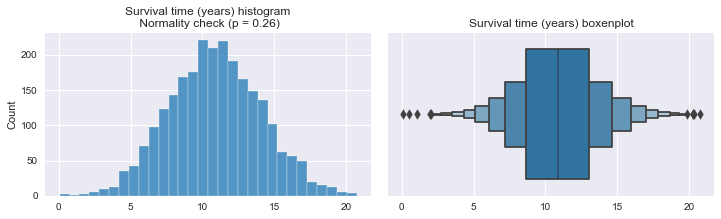

In [98]:
# Set figure space
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={"hspace": 0, "wspace": 0.05})

# Test for normality
test_stat, p = scipy.stats.shapiro(data[target])

# Plot, left side
sns.histplot(data=data, x=target, ax=ax[0], color='tab:blue', bins=30)
ax[0].set_title(f'{target} histogram\n Normality check (p = {round(p, 2)})', fontsize=12)
ax[0].set_xlabel('')

# Plot, right side
sns.boxenplot(data=data, x=target, ax=ax[1], color='tab:blue')
ax[1].set_title(f'{target} boxenplot', fontsize=12)
ax[1].set_xlabel('')
plt.show()

### Numeric Feature Distribution

The plots below show the distributions of numeric features in the data set. From the visualization we can see that most cell profile data are approximately normally distributed. Age is clearly not normally distributed, but roughly uniformly distributed. Fliers/potential outliers are noticeable from these visuals as well.


Numerical Feature Distributions:



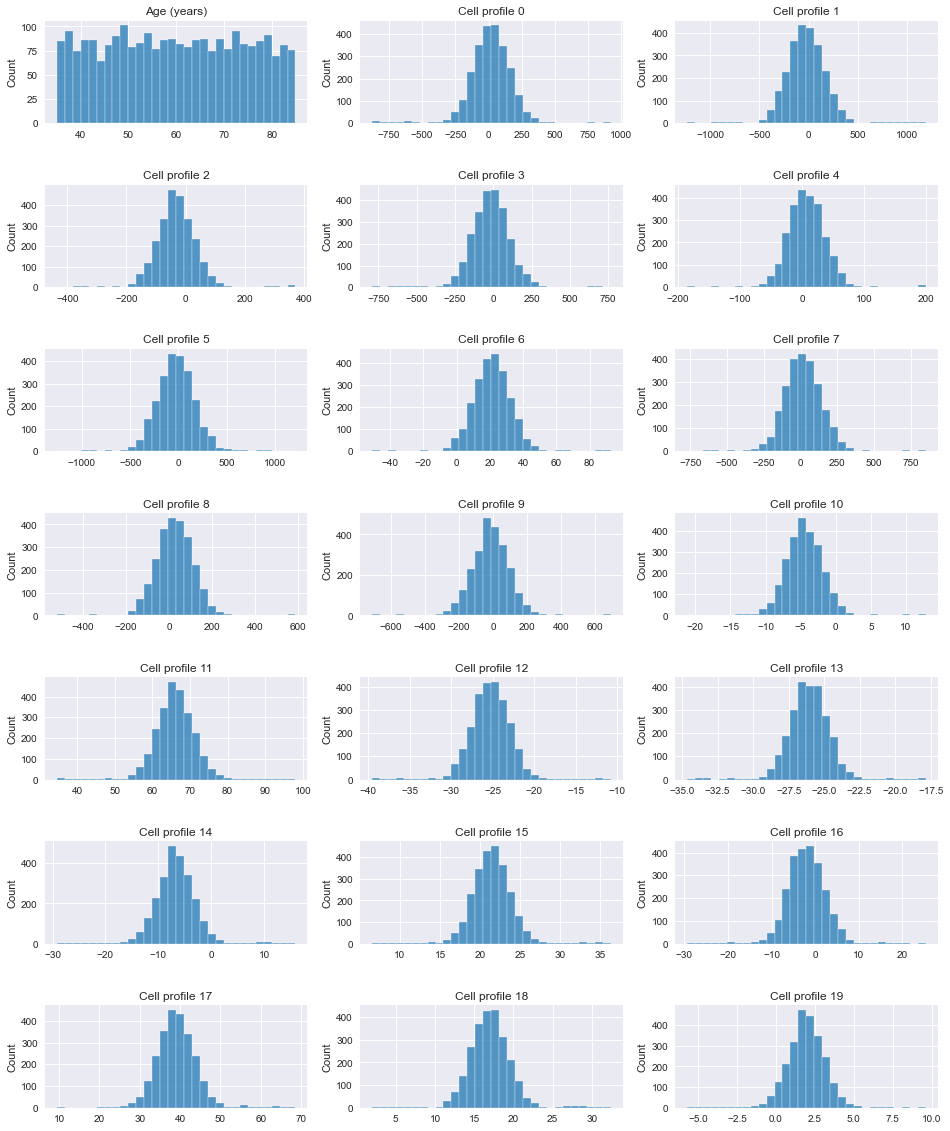

In [99]:
# Plot numeric feature distributions
print('\nNumerical Feature Distributions:\n')
num_feature_dist_plot(df=X, n_col=3, fig_width=16, fig_height=20, hspace=0.6, wspace=0.2)

### Categorical Feature Class Balance

Heavy class imblance exists among racial groups. Observations with missing racial group data will be dropped from analysis


Categorical Feature Class Balance:



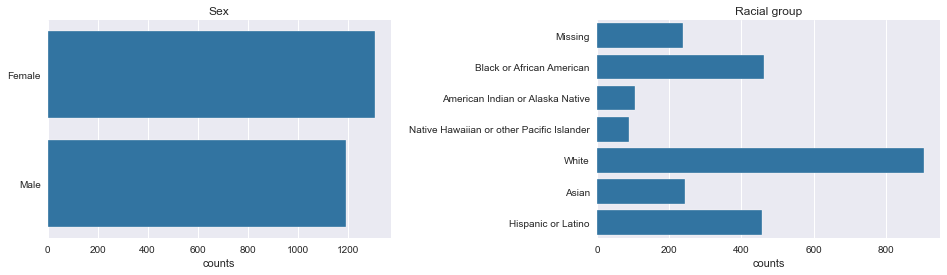

In [70]:
# Plot non-numeric feature distributions
print('\nCategorical Feature Class Balance:\n')
cat_feature_count_plot(df=X, n_col=2, fig_width=16, fig_height=4, hspace=0.6, wspace=0.6)

# Missing Data Handling

## Cell Profile Imputation

Cell profile features are continuous. We can implement a simple imputation method to fill in these missing values. All other information can then be used to impute missing racial group data.

In [74]:
data.dropna(subset=['Racial group'], inplace=True)
data.describe()

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
count,2263.000000,2241.000000,2263.000000,2263.000000,2263.000000,2263.000000,2239.000000,2245.000000,2241.000000,2263.000000,...,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000
mean,59.710431,17.870210,-19.725929,-30.622571,-16.388434,8.340553,-25.837651,21.525077,19.568734,25.750647,...,66.098332,-25.227646,-26.059229,-6.650678,21.512976,-1.982761,39.146643,17.037279,1.950792,10.899345
std,14.355699,163.916259,216.980801,73.831390,139.493101,34.567086,224.670143,12.859820,151.482982,100.636142,...,5.688038,2.585270,1.522398,3.963122,2.695252,4.874221,5.214694,2.766072,1.361472,3.202481
min,35.001743,-875.861137,-1236.026054,-435.425713,-793.308449,-185.306389,-1260.801076,-50.924635,-771.666265,-517.142056,...,34.532265,-39.552357,-34.658710,-28.330036,6.632689,-29.405554,9.512503,1.953396,-5.709943,0.072005
25%,47.719989,-69.085725,-145.460955,-70.108153,-89.934292,-11.361851,-150.648572,14.121036,-65.991101,-28.023512,...,63.094254,-26.632150,-26.896388,-8.822978,19.970670,-4.715455,35.991035,15.389584,1.245832,8.630323
50%,59.535795,20.920140,-22.672711,-32.659552,-13.729288,7.531457,-24.881970,21.431829,18.355849,25.248989,...,66.064430,-25.226845,-26.065826,-6.671878,21.460463,-1.980462,38.974373,16.957558,1.979007,10.877272
75%,72.131630,112.440882,101.252265,6.992988,61.223804,27.403106,100.644503,28.727346,102.951017,82.565356,...,69.176548,-23.739476,-25.184390,-4.457839,22.967842,0.782923,42.025080,18.514351,2.729028,13.070113
max,84.944242,918.594159,1191.275835,371.666717,716.236011,198.980592,1211.526446,92.571795,849.890335,587.655878,...,98.026489,-10.783654,-17.846529,15.340671,36.261654,25.352072,68.617393,32.375202,9.615926,20.721592


In [86]:
data = data[data['Racial group'].notna()]
abs(data.astype('object').describe().iloc[0] - len(data))

Age (years)               0.0
Sex                         0
Racial group                0
Cell profile 0           22.0
Cell profile 1            0.0
Cell profile 2            0.0
Cell profile 3            0.0
Cell profile 4            0.0
Cell profile 5           24.0
Cell profile 6           18.0
Cell profile 7           22.0
Cell profile 8            0.0
Cell profile 9            0.0
Cell profile 10           0.0
Cell profile 11           0.0
Cell profile 12           0.0
Cell profile 13           0.0
Cell profile 14           0.0
Cell profile 15           0.0
Cell profile 16           0.0
Cell profile 17           0.0
Cell profile 18           0.0
Cell profile 19           0.0
Survival time (years)     0.0
Name: count, dtype: object